In [256]:
# Import necessary libraries

import pandas as pd
import numpy as np

In [257]:
# Import king county data from Data folder

raw = pd.read_csv('Data/kc_house_data.csv')

raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [258]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

- The **id** column will not be suitable to include in a model for the data.
- The **date** that the house was sold (date) could be interesting, but I think that I would leave it out of an initial model.
- The numerical features **bedrooms**, **bathrooms**, **sqft_living** and **sqft_lot** seem like good candidates for model features.
- The number of **floors** seems like it *might* be correlated with sqft_living, so we will see if it still has significant predictive power if both are included in the model.
- I am curious to dig into the **waterfront** feature more; I have a feeling that it will make a great non-numerical feature for the model.
- I am not sure what to think about **view**s until I look at the column values; if it is a list of places you can see from the home, then making a new feature "number of views" equal to the length of the list could be valuable.
- The **condition** looks to be a rating which describes how little or how much deferred maintenance the home has suffered, and how much "life" the home has left in it based on its current status (1 - excessive deferred maintenance, little life left, to 5 - up to date maintenance, life extended by maintenance and overhauling.)
- The **grade** refers to the construction quality of improvements (up to code or not, quality of materials, custom versus simple design, etc.) Based on the number of different codes (13) and their meanings, you could create a new feature based on whether or not the building is "up to code" (codes 1-5) or even try to create a "luxury" feature (maybe codes 10-13) - but I think the cutoff between codes to go from average to luxury is not so clear.
- Both **sqft_above** (square footage of house apart from basement) and **sqft_basement** (square footage of the basement) may be correlated with each other and possibly sqft_living (square footage of living space in the house.)
- **yr_built** and **yr_renovated** should be good candidates for modeling - I probably need to scale and normalize these since the year will be a relatively large number (nearly 2000) for almost all houses. I'm guessing that we will also have missing values in yr_renovated for houses that haven't been renovated. It might be prudent to create a new column for yes / no has it been renovated, then fill in these missing values with the mean or median. (Or mode? Just thought to consider the mode.)
- I don't think that the **zipcode** will be valuable information for modeling, though it could be used to join additional data to this data. Or, zipcode could be converted to a categorical variable of sorts, then one-hot encoded.
- **lat** and **long** (latitude and longititude) seem like they would not be valuable, but who knows? Maybe correlated with zipcode as a categorical variable? But the fact that they would be treated separately by the model seems odd. I have never heard of someone searching for a house with a particular latitude, regardless of longitude.
- **sqft_living15** and **sqft_lot15** are interesting - the square footage of interior living space and lot size of the 15 nearest neighbors. These might directly be correlated with sqft_living and sqft_lot, but you could engineer a new feature indicating whether the house is generally smaller or larger than that of the neighbors.

In [4]:
# Exploring the waterfront feature a little more; start by viewing the
# first 5 rows

raw.waterfront.head()

0    NaN
1     NO
2     NO
3     NO
4     NO
Name: waterfront, dtype: object

It looks to be a yes/no Boolean with some null / missing values.

In [5]:
# what are the possible non-null values for waterfront?
raw.waterfront.value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [6]:
# how many null values does waterfront have?

raw.waterfront.isnull().value_counts()

False    19221
True      2376
Name: waterfront, dtype: int64

In [7]:
# what percentage of the data has a null value for waterfront?

2376/19221

0.1236147963165288

12% of data does not have a waterfront tag (yes or no.) I could fill this data in with the mode (NO) and make the column completely Boolean. Should I keep track of whether or not the original data had a tag? It seems like more trouble than it is worth.

In [8]:
# Exploring the view feature a little more; start with a glance at the
# first five rows

raw.view.head()

0    NONE
1    NONE
2    NONE
3    NONE
4    NONE
Name: view, dtype: object

In [9]:
#take a look at the value_counts; what possible values are there for view?

raw.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [10]:
# how many records are null?
# which is DIFFERENT by the way from none. NONE is a legit category for
# view in this circumstance
raw.view.isnull().value_counts()

False    21534
True        63
Name: view, dtype: int64

So the view feature is actually a rating of the quality of the view from the home of nature and various sights.

We are missing far fewer values for this feature; I might look into dropping them, but only after exploring missing values in other features, too, and looking at the total number of records that will be dropped due to missing values for various features.

In [11]:
# while I'm thinking about null values, how many features have NaN null
# values? and how many do they have?
raw.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

yr_renovated is, by far, the feature with the biggest number of missing values. I assume that this means that those houses have never been renovated. My plan is to create a new Boolean feature, renovated, and then fill in the missing values with either the mean or median (after I take a look at the distribution of yr_renovated.)

In [12]:
# Lastly, for this stage, check out sqft_basement - why is it an object?

raw.sqft_basement.head()

0      0.0
1    400.0
2      0.0
3    910.0
4      0.0
Name: sqft_basement, dtype: object

In [13]:
# describe the sqft_basement column - is it really type string??
raw.sqft_basement.describe()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object

In [14]:
# when I tried to cast raw.sqft_basement to float, it threw an error for ?

raw.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2250.0        1
2720.0        1
248.0         1
1024.0        1
2390.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [15]:
# If I only deal with records for which sqft_basement is NOT '?', can I
# cast the entire column to float? While I'm at it, let's check the stats
# for this column w/o the null values, assuming I can cast it to float.

raw.loc[ raw.sqft_basement != '?', 'sqft_basement' ].astype(float).\
describe()

count    21143.000000
mean       291.851724
std        442.498337
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64

Excellent. So ? is the placeholder for missing values in the "sqft_basement" column. If I drop these records or replace the '?' values with the mean, median or mode then I can cast the entire column to float.

Also, a note based on the .describe() stats for the sqft_basement column without missing values: obviously, some houses don't have basements. In fact, at least half of houses in this dataset don't have basements. Should I make a new column - has basement or doesn't have basement? And then maybe exclude the basement square footage from the set? Or should I try to include it somehow, even though half (or more) of houses don't have a basement at all for which to record square footage?

#### Next Steps (temporary cell)

My next steps will be to create a copy of the raw dataframe on which to perform preprocessing.

The first step of preprocessing will be to deal with missing values. Some features with missing values have already been identified, and I have speculated above about some strategies to deal with those missing values. However, I also need to check the value_counts for each feature to see if there are any "missing" values which haven't come to my attention yet because they are not encoded as type NULL and I haven't explored that feature further yet. I need to do this step (checking the value counts for each feature) before I make any decisions about dropping data, to ensure that I keep as much data as possible. Dealing with missing values may entail the creation of some new features as detailed above in my proposed strategies for dealing with missing values.

* Can I deal with missing values on the entire dataset all at once, or do I need to split my data into training and test sets beforehand? If so, how do I deal with missing values for the test set? Do I need to create a function which can "blindly" deal with missing values in the test set, in a similar fashion to how I dealt with missing values in the training set? If so, do I hardcode the value with which I am replacing missing values in a feature, or do I program the function to find the corresponding value for the test set (e.g. the mean, median or mode of the non-missing values for that feature.)

After dealing with missing values, I think I can move on to exploring the distribution of each feature and scaling/normalizing/log-transforming as appropriate. I want to keep a careful record of how I have scaled/normalized/log-transformed any features so that I can interpret the predictions made by my model appropriately when the time comes (and also, so that I can feed in the correctly scaled x-values when making predictions for new values outside of the original dataset.) This stage will involve plotting to explore the distributions, and separating out categorical variables to treat separately.

Talking about this step makes me realize that I have two questions:

- Do I need to split my data into training / test sets BEFORE dealing with missing values? If so, do I deal with missing values separately on the test set before feeding it into my model?



- I think that I DO need to split my data into training / test sets before scaling/normalizing/log-transforming any features. So I need to do that, and then work carefully to not re-fit the feature scalers and normalizers I use when transforming the test data. I also need to do something similar when one-hot encoding categorical variables (I guess. Not sure if this matters for OHE; it kind of seems like it doesn't, but maybe to be on the safe side - if my test data just HAPPENS not to have any grade 3 homes in it, for example, I still want that label in my test data after one hot encoding.)

#### Update to next steps:

As I am reading [this article](https://towardsdatascience.com/how-to-handle-missing-values-in-cross-validation-96fd569821d0#:~:text=Unless%20we%20use%20constant%20values,serious%20issue%20in%20machine%20learning.), I am realizing that I need to choose a strategy for filling in missing values (mean, median or mode) without looking at the data in question. Or, perhaps I can look at the training set, choose a strategy, set up an Imputer from scikit learn with that strategy, then apply it blindly to the test set.

Section 6.4.6 in [this documentation](https://scikit-learn.org/stable/modules/impute.html) on the SimpleImputer from SciKitLearn provides some interesting information about the results of setting the add_indicator parameter to true for this function (or class object, whatever it is called.) However, it looks like the missing indicator columns should not be used in your linear regression model (??? I'm not sure about this, but this is what I am presently understanding), but you can use a different kind of machine learning model to analyze that information. I am, for the time being, going to impute the values of waterfront without adding a missing indicator, but I hope that I can add this functionality later.

#### NEW next steps after doing a little bit of research

Trying to make a plan for how to proceed with splitting my data into training and testing sets led me to do a little bit of research on cross-validation. [This article](https://towardsdatascience.com/understanding-cross-validation-419dbd47e9bd#:~:text=Cross%20validation%20is%20a%20technique,how%20well%20our%20model%20generalizes) helped me to understand that I actually need to split my data before performing cross-validation.

So I am going to split my data now into training and test sets, then perform k-fold cross validation on my training data. The average R^2 for my model's performance on the test data for each of the k-folds of training and test data will help me (I hope) to make decisions about how to tune my parameters / select features to include.

I will need to use SimpleImputer and possibly other functions to make it possible for my program to deal with missing values, feature scaling/normalizing/transforming and encoding categorical variables within each fold.

In [259]:
# Import libraries for splitting data into train, validate and test sets

from sklearn.model_selection import train_test_split

In [260]:
# Split the data 70%/30% into training and test sets
# Drop id, date (for now) and price from X data

X_train, X_test, y_train, y_test = train_test_split(
    raw.drop(['price', 'date', 'id'], axis=1),
    raw['price'],
    test_size=0.3,
    random_state=421,
    shuffle=True
)

In [261]:
# Verify that X_train contains 70% of data, not including price or id

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 489 to 19799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15117 non-null  int64  
 1   bathrooms      15117 non-null  float64
 2   sqft_living    15117 non-null  int64  
 3   sqft_lot       15117 non-null  int64  
 4   floors         15117 non-null  float64
 5   waterfront     13470 non-null  object 
 6   view           15073 non-null  object 
 7   condition      15117 non-null  object 
 8   grade          15117 non-null  object 
 9   sqft_above     15117 non-null  int64  
 10  sqft_basement  15117 non-null  object 
 11  yr_built       15117 non-null  int64  
 12  yr_renovated   12447 non-null  float64
 13  zipcode        15117 non-null  int64  
 14  lat            15117 non-null  float64
 15  long           15117 non-null  float64
 16  sqft_living15  15117 non-null  int64  
 17  sqft_lot15     15117 non-null  int64  
dtypes: f

In [ ]:
# Now let's work on a set of actions / functions to process data after the
# split

# check distribution of numerical features - do any need to be scaled?
# normalized? log-transformed?

# I think I should re-examine waterfront and view now that I am dealing
# with my actual training set xD and deal with their missing data

# deal with missing data in waterfront; use simple imputer to impute 'NO'
# for null values

# deal with missing data in "view"; impute the mode, 'NONE'

# deal with missing data in yr_renovated; create new column 'renovated'
# with a boolean value for yes or no, then impute the mean, median or mode
# (depending on distribution of data) in original column

In [11]:
X_train.waterfront.value_counts()

NO     13371
YES       99
Name: waterfront, dtype: int64

In [12]:
X_train.waterfront.isna().sum()

1647

X_train waterfront has a LOT of missing values. Impute the mode, which is "NO", in this case.

In [13]:
X_train.view.value_counts()

NONE         13593
AVERAGE        680
GOOD           363
EXCELLENT      223
FAIR           214
Name: view, dtype: int64

In [14]:
X_train.view.isna().sum()

44

X_train view doesn't have so many missing values. I think I will still impute the mode, which is "NONE".

In this case, and in the waterfront case, I think we are (somewhat safely?) assuming that most houses don't have a waterfront or great views if not recorded.

In [15]:
X_train.yr_renovated.value_counts()

0.0       11916
2014.0       52
2013.0       22
2007.0       21
2003.0       21
          ...  
1956.0        1
1953.0        1
1971.0        1
1946.0        1
1954.0        1
Name: yr_renovated, Length: 67, dtype: int64

A LOT of houses have not been renovated! Maybe it makes the most sense to get rid of this column, after recording whether or not a house has been renovated?

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


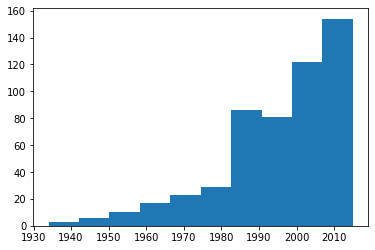

In [262]:
# Glance at distribution of "yr_renovated" without 0s

import matplotlib.pyplot as plt

data = X_train.yr_renovated.loc[ X_train.yr_renovated != 0 ]

plt.hist(data);

Though there is interesting information in the yr_renovated column, it just doesn't seem right to include this feature when it only applies to slightly more than a third of our data.

In [17]:
for column in X_train.columns:
    print(column)
    print(X_train[column].value_counts())

bedrooms
3     6876
4     4839
2     1908
5     1127
6      174
1      148
7       30
8        9
9        3
10       2
11       1
Name: bedrooms, dtype: int64
bathrooms
2.50    3773
1.00    2650
1.75    2140
2.25    1461
2.00    1380
1.50     999
2.75     831
3.00     537
3.50     511
3.25     396
3.75     111
4.00      92
4.50      67
4.25      52
0.75      47
4.75      16
5.00      13
5.25      12
5.50       8
1.25       6
6.00       4
5.75       2
6.25       2
8.00       2
0.50       2
6.75       1
7.50       1
6.50       1
Name: bathrooms, dtype: int64
sqft_living
1440    96
1660    93
1300    92
1250    91
1480    90
        ..
2223     1
1658     1
5760     1
2095     1
2031     1
Name: sqft_living, Length: 894, dtype: int64
sqft_lot
5000     252
6000     195
4000     173
7200     138
4800      84
        ... 
7791       1
65836      1
13938      1
7799       1
53250      1
Name: sqft_lot, Length: 7775, dtype: int64
floors
1.0    7477
2.0    5780
1.5    1310
3.0     426
2.5     1

In [ ]:
# DONE impute waterfront values with mode

# DONE change waterfront values to Bools

# DONE impute view values with mode

# DONE change view values to numerical rating scale (makes sense in this case)

# DONE convert condition and grade to numerical rating scales

# DONE impute '?' values with the mean or median for sqft_basement

# DONE also, a lot of houses just don't HAVE basements; change to yes/no, then
# drop this feature?

# drop lat and long - maybe not?? it might be ok to include in a
# predictive model?

# DONE engineer a new feature from sqft_living15 and sqft_lot15 - is this
# house bigger or smaller than the neighbors?

# DONE one hot encode zipcode

After completing the above, we are ready to scale, normalize and possibly log-transform our features. There is only one "categorical" feature remaining - zipcode - so we can leave that one out and examine the distributions of the others to decide on a scaling, normalizing or log-transforming approach, if applicable, and then rejoin everything for training our model!

In [263]:
# make a copy of X_train to store modified data as we process it

X_train_preprocessed = X_train.copy()

In [264]:
# map grade feature to first character in string, which is a numerical grade

X_train_preprocessed.loc[:, 'grade'] = X_train_preprocessed['grade'].map(lambda x: x[0])

In [265]:
# convert grade feature to int

X_train_preprocessed.loc[:, 'grade'] = X_train_preprocessed.grade.astype(int)

In [266]:
# convert condition score to numerical

# outstanding question - should the scores start at 0 or 1? not sure

X_train_preprocessed.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)

In [267]:
# convert view rating to numerical
# it seems natural that a view of NONE should map to 0, so start rating scale at 0

X_train_preprocessed.view.replace({'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}, inplace=True)

In [268]:
# replace null values in view with the mode, which turns out to be 0

view_mode = X_train_preprocessed.view.mode()[0]

X_train_preprocessed.view.fillna(view_mode, inplace=True)

In [269]:
# engineer new Boolean feature: renovated

X_train_preprocessed['renovated'] = 0

# if yr_renovated is NOT zero, change 'renovated' value to 1

X_train_preprocessed.loc[ X_train_preprocessed['yr_renovated'] != 0, 'renovated' ] = 1

In [270]:
# impute waterfront with mode

# i.e. assume that houses with missing waterfront value are NOT on a waterfront

X_train_preprocessed['waterfront'].fillna(value='NO', inplace=True)

In [271]:
# convert waterfront values to 0s and 1s

X_train_preprocessed['waterfront'].replace({'NO': 0, 'YES': 1}, inplace=True)

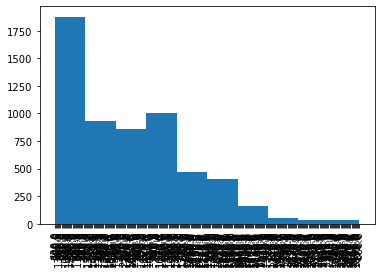

In [272]:
# get some idea of the distribution of sqft_basement

data = X_train_preprocessed.loc[ ((X_train_preprocessed['sqft_basement'] != '0.0')\
                                  & (X_train_preprocessed['sqft_basement'] != '?')), 'sqft_basement'] 

plt.hist(data.values)

plt.xticks(rotation=90);

In [273]:
# since sqft_basement data is skewed, fill missing values with the median

# the median basement square footage is 0; assume houses with no sqft_basement reported have no basement

med=X_train_preprocessed.loc[ (X_train_preprocessed['sqft_basement'] != '?'), 'sqft_basement' ].astype(float).median()

In [274]:
# replace ?s with 0, the median basement square footage according to above

X_train_preprocessed['sqft_basement'].replace(to_replace='?', value=med, inplace=True)

In [275]:
# cast basement square footage values to type float, now that ?s are gone

X_train_preprocessed.sqft_basement = X_train_preprocessed.sqft_basement.astype(float)

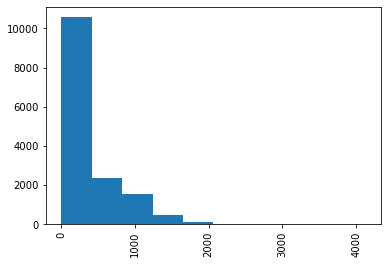

In [276]:
# look at new distribution of sqft_basement

data = X_train_preprocessed.sqft_basement

plt.hist(data.values)

plt.xticks(rotation=90);

In [277]:
# engineer new feature, 'has_basement'

X_train_preprocessed['has_basement'] = 1

# if sqft_basement value is 0, change 'has_basement' to false

X_train_preprocessed.loc[X_train_preprocessed['sqft_basement'] == 0, 'has_basement' ] = 0

In [278]:
# now the only feature with missing values is yr_renovated

X_train_preprocessed.isna().sum()

bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     2670
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
renovated           0
has_basement        0
dtype: int64

In [279]:
# engineer a new feature - how does this house compare to neighboring houses?

X_train_preprocessed['comparison_factor'] =\
(X_train_preprocessed['sqft_living'] - X_train_preprocessed['sqft_living15']) / X_train_preprocessed['sqft_living15']

In [280]:
# inspect first few rows of preprocessed data so far

X_train_preprocessed.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement,comparison_factor
489,5,2.50,3400,9500,2.0,0,1.0,3,8,3400,...,1977,0.0,98027,47.5645,-122.082,3080,11081,0,0,0.103896
9082,4,2.50,2800,6874,2.0,0,0.0,2,9,2170,...,1990,0.0,98112,47.6215,-122.290,1430,6240,0,1,0.958042
14422,4,2.50,1820,8217,1.0,0,0.0,2,7,1120,...,1987,0.0,98001,47.2630,-122.242,1310,8217,0,1,0.389313
13361,3,1.75,2140,13068,1.0,0,0.0,3,7,1460,...,1974,0.0,98092,47.3099,-122.197,2090,17424,0,1,0.023923
14781,2,1.00,880,6900,1.0,0,0.0,2,6,880,...,1943,0.0,98056,47.4903,-122.191,1060,8000,0,0,-0.169811


In [281]:
# now comes the time to one hot encode zipcode

X_train_preprocessed.zipcode.value_counts()

98103    432
98115    416
98038    415
98052    406
98117    398
        ... 
98032     74
98010     72
98024     55
98148     39
98039     36
Name: zipcode, Length: 70, dtype: int64

In [282]:
# there are 70 unique zipcodes

# ohe-ing the zipcodes is going to create 70 new columns!!!

from sklearn.preprocessing import OneHotEncoder

zip_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

zip_ohe.fit(X_train_preprocessed[['zipcode']])

new_zipcode_cols = zip_ohe.get_feature_names(input_features=['zipcode'])

In [283]:
X_train_ohe = pd.DataFrame(zip_ohe.fit_transform(X_train[['zipcode']]), columns = new_zipcode_cols,\
                          index = X_train_preprocessed.index)

In [284]:
X_train_preprocessed = pd.concat([X_train_preprocessed.drop('zipcode', axis=1), X_train_ohe], axis=1)

In [285]:
X_train_preprocessed.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
489,5,2.50,3400,9500,2.0,0,1.0,3,8,3400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9082,4,2.50,2800,6874,2.0,0,0.0,2,9,2170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14422,4,2.50,1820,8217,1.0,0,0.0,2,7,1120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13361,3,1.75,2140,13068,1.0,0,0.0,3,7,1460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14781,2,1.00,880,6900,1.0,0,0.0,2,6,880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
X_train_preprocessed.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'renovated', 'has_basement',
       'comparison_factor', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_980

In [287]:
cols_to_be_scaled = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade',\
                     'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15',\
                    'comparison_factor']

# note to self: DROP YR_RENOVATED BEFORE MODELING

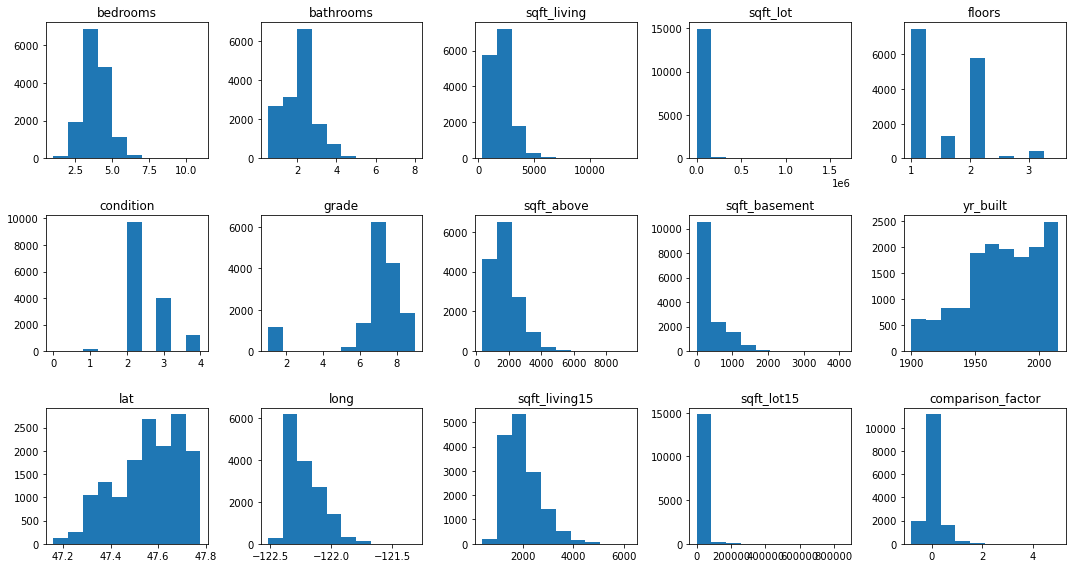

In [288]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

i = 0
for col in cols_to_be_scaled:
    ax = axes[i//5][i%5]
    ax.hist(X_train_preprocessed[col].values)
    ax.set_title(col);
    i += 1
    
fig.tight_layout()

Comment on distributions of features:

Skewed distributions which could be log-transformed:
- bathrooms
- sqft_living
- sqft_lot
- floors
- condition
- grade
- sqft_above
- sqft_basement
- yr_built
- lat
- long
- sqft_living15
- sqft_lot_15

So basically everything should be log-transformed except for bedrooms and comparison_factor.

Then scale.

In [290]:
# create a df to hold scaled data

X_train_pp_scaled = X_train_preprocessed[cols_to_be_scaled].copy()

for col in cols_to_be_scaled:
    mu = np.mean(X_train_pp_scaled[col])
    sigma = np.std(X_train_pp_scaled[col])
    X_train_pp_scaled[col] = (X_train_pp_scaled[col] - mu)/sigma
    
X_train_pp_scaled.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,comparison_factor
489,1.805254,0.498767,1.430821,-0.133196,0.935447,0.903920,0.549087,1.940461,-0.650949,0.205540,0.032026,0.950174,1.588507,-0.062825,0.152965
9082,0.696715,0.498767,0.777361,-0.197481,0.935447,-0.634708,1.069758,0.455687,0.777294,0.647780,0.442252,-0.536927,-0.818602,-0.245140,2.798210
14422,0.696715,0.498767,-0.289958,-0.164604,-0.915732,-0.634708,0.028415,-0.811802,0.935988,0.545724,-2.137851,-0.193750,-0.993665,-0.170685,1.036886
13361,-0.411825,-0.482262,0.058555,-0.045849,-0.915732,0.903920,0.028415,-0.401377,0.890647,0.103484,-1.800314,0.127979,0.144241,0.176057,-0.094706
14781,-1.520365,-1.463292,-1.313712,-0.196845,-0.915732,-0.634708,-0.492256,-1.101514,-0.650949,-0.951088,-0.501987,0.170876,-1.358378,-0.178857,-0.694692


In [291]:
# rejoin scaled columns to the rest of preprocessed data

X_train_preprocessed = pd.concat([X_train_preprocessed.drop(cols_to_be_scaled, axis=1), X_train_pp_scaled], axis=1)

X_train_preprocessed.head()

,waterfront,view,yr_renovated,renovated,has_basement,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,comparison_factor
489,0,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.903920,0.549087,1.940461,-0.650949,0.205540,0.032026,0.950174,1.588507,-0.062825,0.152965
9082,0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,0.0,...,-0.634708,1.069758,0.455687,0.777294,0.647780,0.442252,-0.536927,-0.818602,-0.245140,2.798210
14422,0,0.0,0.0,0,1,1.0,0.0,0.0,0.0,0.0,...,-0.634708,0.028415,-0.811802,0.935988,0.545724,-2.137851,-0.193750,-0.993665,-0.170685,1.036886
13361,0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.903920,0.028415,-0.401377,0.890647,0.103484,-1.800314,0.127979,0.144241,0.176057,-0.094706
14781,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,-0.634708,-0.492256,-1.101514,-0.650949,-0.951088,-0.501987,0.170876,-1.358378,-0.178857,-0.694692


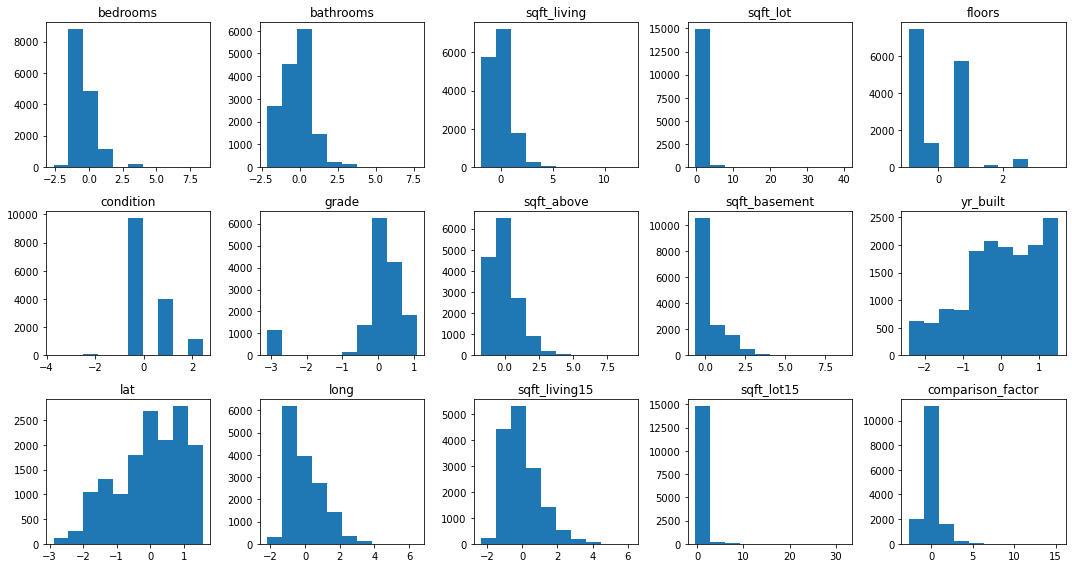

In [292]:
# reexamine distributions

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

i = 0
for col in cols_to_be_scaled:
    ax = axes[i//5][i%5]
    ax.hist(X_train_preprocessed[col].values)
    ax.set_title(col);
    i += 1
    
fig.tight_layout()

In [293]:
# drop yr_renovated

X_train_preprocessed.drop('yr_renovated', axis=1, inplace=True)

I think some of the features should be log-transformed prior to scaling, and maybe I need to scale my Bools somehow? (As in, if some things are 0 or 1, but the scaled data is centered on 0, does this matter?) But for now, I am going to build my baseline model.

In [299]:
# first, using statsmodels, so I can get some info about p-values

# import necessary packages
import statsmodels.api as sm
from statsmodels.formula.api import ols

# build the formula string
outcome = 'y_train'
predictors = X_train_preprocessed
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

# pass formula string and concatenated training data to ordinary least squares
model = ols(formula=formula, data=pd.concat([X_train_preprocessed,y_train], axis=1)).fit()

In [300]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     731.2
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:27:56   Log-Likelihood:            -2.0258e+05
No. Observations:               15117   AIC:                         4.053e+05
Df Residuals:                   15028   BIC:                         4.060e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.285e+05   2675.179    197.556      0.000    5.23e+05    5.34e+05
waterfront         7.095e+05   1.77e+04     40.053      0.000    6.75e+05    7.44e+05
view               5.945e+04   2050.768     28.991      0.000    5.54e+04    6.35e+04
renovated          1.223e+04   3238.656      3.775      0.000    5877.208    1.86e+04
has_basement      -4369.4660   5145.436     -0.849      0.396   -1.45e+04    5716.216
zipcode_98001     -1.378e+05   2.13e+04     -6.484      0.000   -1.79e+05   -9.61e+04
zipcode_98002     -1.039e+05   2.33e+04     -4.465      0.000    -1.5e+05   -5.83e+04
zipcode_98003     -1.457e+05   2.22e+04     -6.557      0.000   -1.89e+05   -1.02e+05
zipcode_98004      5.622e+05   1.15e+04     48.835      0.000     5.4e+05    5.85e+05
zipcode_98005      1.347e+05   1.63e+04      8.254      0.000    1.03e+05    1.67e+05
zipcode_98006      9.621e+04   9523.497     10.103      0.000    7.75e+04    1.15e+05
zipcode_98007      6.264e+04   1.77e+04      3.541      0.000     2.8e+04    9.73e+04
zipcode_98008       6.49e+04   1.37e+04      4.731      0.000     3.8e+04    9.18e+04
zipcode_98010      -1.17e+04    2.7e+04     -0.434      0.664   -6.45e+04    4.11e+04
zipcode_98011     -1.436e+05   2.03e+04     -7.059      0.000   -1.83e+05   -1.04e+05
zipcode_98014      -6.05e+04   2.84e+04     -2.126      0.033   -1.16e+05   -4731.510
zipcode_98019      -1.22e+05   2.49e+04     -4.891      0.000   -1.71e+05   -7.31e+04
zipcode_98022     -4.334e+04   3.03e+04     -1.430      0.153   -1.03e+05    1.61e+04
zipcode_98023     -1.753e+05   2.28e+04     -7.705      0.000    -2.2e+05   -1.31e+05
zipcode_98024          3e+04   2.75e+04      1.089      0.276    -2.4e+04     8.4e+04
zipcode_98027      2.099e+04   1.37e+04      1.530      0.126   -5905.586    4.79e+04
zipcode_98028      -1.49e+05   1.88e+04     -7.926      0.000   -1.86e+05   -1.12e+05
zipcode_98029      8.637e+04   1.59e+04      5.439      0.000    5.52e+04    1.17e+05
zipcode_98030     -1.272e+05   1.82e+04     -6.989      0.000   -1.63e+05   -9.15e+04
zipcode_98031     -1.285e+05    1.6e+04     -8.045      0.000    -1.6e+05   -9.72e+04
zipcode_98032     -1.497e+05   2.35e+04     -6.373      0.000   -1.96e+05   -1.04e+05
zipcode_98033      1.362e+05   1.36e+04     10.040      0.000     1.1e+05    1.63e+05
zipcode_98034     -5.737e+04   1.51e+04     -3.803      0.000   -8.69e+04   -2.78e+04
zipcode_98038     -7.376e+04   1.83e+04     -4.036      0.000    -1.1e+05   -3.79e+04
zipcode_98039       9.39e+05   2.72e+04     34.581      0.000    8.86e+05    9.92e+05
zipcode_98040      3.064e+05   1.12e+04     27.345      0.000    2.84e+05    3.28e+05
zipcode_98042     -1.086e+05   1.69e+04     -6.426      0.000   -1.42e+05   -7.55e+04
zipcode_98045      3.413e+04   2.88e+04      1.183      0.237   -2.24e+04

For a baseline model, I think this is not bad. The coefficient of determination is 81.1%, so our baseline model (in theory) is explaining about 81% of the variance in price.

Our condition number is huge. If the purpose of this model is primarily predictive, this might be fine; for an inferential model, this would be worrisome.

Looking at the confidence intervals provided for the coefficients, there are some interesting observations to be made. To name a few,...

The base price of a house appears to be around \$52,300 without the influence of other features. I guess this is the value of "being a home owner" if all that entailed was a piece of paper saying that you were, and there were no actual physical house attached with square footage and other features like location. =)

The confidence interval for "has_basement" includes zero, though it is such a HUGE interval and it barely dips below zero in relative terms.

The effect of renovations is also indeterminate based on this model. I wonder if renovated and home_age are correlated and causing multicollinearity, because older homes are possibly more likely to have been renovated?

The confidence intervals for most zipcodes seem to be wide, and some include zero. Some have very low p-values and others have rather high p-values.

The effect of having more bedrooms is *negative* according to this model! And generally, there are just some very wide confidence intervals on the coefficients. Latitude and longitude are apparently statistically significant predictors. I wonder if these are correlated in some way with zipcodes?

I look forward to making a better model!